In [1]:
import geopandas as gpd
import duckdb


import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx


In [2]:
duckdb.sql("SELECT 42").show()

┌───────┐
│  42   │
│ int32 │
├───────┤
│    42 │
└───────┘



In [3]:
## PBF history runterladen  
# https://osm-internal.download.geofabrik.de/europe/germany/brandenburg.html


In [4]:
# alles changsets runterlade, (nur hier sind die hashtags drin) changesets-latest.osm.bz2  
# https://planet.openstreetmap.org/planet/


# zeitlich and räumlich  filtern (geht ziemlich lang, > 15min)
# # grobe Deutschland-BBox: lon_min,lat_min,lon_max,lat_max
# DE_BBOX="5.5,47.2,15.1,55.1"

# osmium changeset-filter \
#   --after 2020-01-01T00:00:00Z \
#   --bbox $DE_BBOX \
#   -o changesets-DE-2020plus.osm.bz2 \
#   changesets-251006.osm.bz2


###### viellericht alternative besser , denn das dauert 1 h
# bunzip2 -k ~/ohsome-planet/data/changesets-DE-2020plus.osm.bz2

# # in postgres erstellen
# cd ~/ChangesetMD
# python3 changesetmd.py \
#   -c \
#   -H localhost \
#   -u osm \
#   -p osm \
#   -d changesetmd

# # in postgres reinladen
# python3 changesetmd.py \
#   -f ~/ohsome-planet/data/changesets-DE-2020plus.osm \
#   -H localhost \
#   -u osm \
#   -p osm \
#   -d changesetmd


######  alternative rust bib zu csv, dann csv in postgres laden ....



In [5]:
# simon@LAPTOP-T25KRUB6:~/ohsome-planet$ java -jar ohsome-planet-cli/target/ohsome-planet.jar contributions \
#   --pbf data/berlin-internal.osh.pbf \
#   --output out-berlin \
#   --overwrite
# read blocks 100% │████████████████│ 362/362 MiB (0:00:00 / 0:00:00) 2848 blocks
# process     node 100% │████████████████████│ 2130/2130 blk (0:00:13 / 0:00:00)
# process      way 100% │██████████████████████│ 652/652 blk (0:00:33 / 0:00:00)
# process relation 100% │████████████████████████│ 66/66 blk (0:01:22 / 0:00:00)
# done in 2.084 min


## TODO: TAGS????

In [3]:

duckdb.sql("INSTALL spatial; LOAD spatial;")

duckdb.sql("""
CREATE OR REPLACE TABLE tmp2 AS
SELECT
  ST_GeomFromWKB(geometry) AS geom,
  tags,
  changeset,
  user,
           
FROM read_parquet(
  ['~/ohsome-planet/out-berlin_cs/contributions/history/way*-*-history-contribs.parquet',
   '~/ohsome-planet/out-berlin_cs/contributions/latest/way*-*-latest-contribs.parquet'],
  union_by_name=true
)
WHERE
 (
    COALESCE(changeset.tags.hashtags, '') ILIKE '%#fmc_vorrangnetz%' OR COALESCE(changeset.tags.hashtags, '') ILIKE '%#fmc_vorrangnetz%'
  )
""")


# valid_from >= DATE '2025-01-01' AND

# WHERE tags['highway'] = 'cycleway' OR tags['highway'] = 'path'
# AND length_delta > 0
# user.name == 'fmc_9'

# user.name IN ('fmc_6', 'fmc_7', 'fmc_8', 'fmc_9', 'fmc_10')

# changeset.tags.hashtags IN ('#fmc_vorrangnetz') 


rows = duckdb.sql("SELECT ST_AsText(geom) AS wkt, tags, changeset, user FROM tmp2").fetchall()


gdf = gpd.GeoDataFrame.from_records(rows, columns=["wkt", "tags", "changeset", "user"])
gdf["geometry"] = gpd.GeoSeries.from_wkt(gdf["wkt"])
gdf = gdf.set_geometry("geometry", crs="EPSG:4326")
gdf#.head()



/tmp/ipykernel_211486/2359021050.py:38: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf["geometry"] = gpd.GeoSeries.from_wkt(gdf["wkt"])


,wkt,tags,changeset,user,geometry
0,"LINESTRING (13.51478 52.4530461, 13.5153139 52...","{'destination:ref:to': 'A 117', 'destination:s...","{'id': 170477457, 'created_at': 2025-08-15 11:...","{'id': 23034327, 'name': 'fmc_7'}","LINESTRING (13.51478 52.45305, 13.51531 52.45268)"
1,"LINESTRING (13.4277179 52.4935848, 13.427681 5...","{'smoothness': 'excellent', 'maxspeed': '30', ...","{'id': 169358141, 'created_at': 2025-07-23 17:...","{'id': 23034327, 'name': 'fmc_7'}","LINESTRING (13.42772 52.49358, 13.42768 52.493..."
2,"LINESTRING (13.4502278 52.5074663, 13.4503204 ...","{'cycleway:right:lane': 'advisory', 'highway':...","{'id': 168958675, 'created_at': 2025-07-15 10:...","{'id': 23035092, 'name': 'fmc_9'}","LINESTRING (13.45023 52.50747, 13.45032 52.507..."
3,"LINESTRING (13.2521769 52.5215775, 13.253189 5...","{'cycleway:right:surface': 'asphalt', 'cyclewa...","{'id': 170341846, 'created_at': 2025-08-12 13:...","{'id': 23035092, 'name': 'fmc_9'}","LINESTRING (13.25218 52.52158, 13.25319 52.521..."
4,"LINESTRING (13.1891618 52.4336925, 13.1891087 ...","{'lit': 'yes', 'cycleway': 'track', 'cycleway:...","{'id': 169774921, 'created_at': 2025-07-31 14:...","{'id': 23034332, 'name': 'fmc_8'}","LINESTRING (13.18916 52.43369, 13.18911 52.433..."
...,...,...,...,...,...
12039,"LINESTRING (13.5402893 52.5344666, 13.5406907 ...","{'postal_code': '12681', 'cycleway:both:width'...","{'id': 172783566, 'created_at': 2025-10-03 10:...","{'id': 23034332, 'name': 'fmc_8'}","LINESTRING (13.54029 52.53447, 13.54069 52.534..."
12040,"LINESTRING (13.5399283 52.5344711, 13.5401022 ...","{'name': 'Poelchaustraße', 'lit': 'yes', 'foot...","{'id': 172783566, 'created_at': 2025-10-03 10:...","{'id': 23034332, 'name': 'fmc_8'}","LINESTRING (13.53993 52.53447, 13.5401 52.5344..."
12041,"LINESTRING (13.5416514 52.5344237, 13.5417894 ...","{'highway': 'tertiary', 'foot': 'use_sidepath'...","{'id': 172783566, 'created_at': 2025-10-03 10:...","{'id': 23034332, 'name': 'fmc_8'}","LINESTRING (13.54165 52.53442, 13.54179 52.53441)"
12042,"LINESTRING (13.5412607 52.5344454, 13.5413342 ...","{'cycleway:left:width': '1.5', 'postal_code': ...","{'id': 172783566, 'created_at': 2025-10-03 10:...","{'id': 23034332, 'name': 'fmc_8'}","LINESTRING (13.54126 52.53445, 13.54133 52.534..."


In [4]:
#gdf[gdf.user.str.contains("Emil1887")]

In [5]:
gdf["changeset_id"] = gdf["changeset"].apply(lambda u: u.get("id") if isinstance(u, dict) else None)
gdf["highway"] = gdf["tags"].apply(lambda u: u.get("highway") if isinstance(u, dict) else None)
gdf["hashtags"] = gdf["changeset"].apply(lambda u: u.get("tags").get("hashtags") if isinstance(u, dict) else None)
gdf["user_name"] = gdf["user"].apply(lambda u: u.get("name") if isinstance(u, dict) else None)


In [6]:
gdf=gdf[gdf.highway.notnull()].copy()

In [7]:
gdf.hashtags.value_counts()

hashtags
#fmc-vorrangnetz                      6980
#fmc-vorrangnetz;#maproulette         3021
#fmc_vorrangnetz                      1703
#radverkehrsatlas;#fmc-vorrangnetz      23
Name: count, dtype: int64

In [8]:

##gdf[gdf.user_name == "bicyclett"]#.plot()

In [9]:
gdf

,wkt,tags,changeset,user,geometry,changeset_id,highway,hashtags,user_name
0,"LINESTRING (13.51478 52.4530461, 13.5153139 52...","{'destination:ref:to': 'A 117', 'destination:s...","{'id': 170477457, 'created_at': 2025-08-15 11:...","{'id': 23034327, 'name': 'fmc_7'}","LINESTRING (13.51478 52.45305, 13.51531 52.45268)",170477457,primary,#fmc-vorrangnetz;#maproulette,fmc_7
1,"LINESTRING (13.4277179 52.4935848, 13.427681 5...","{'smoothness': 'excellent', 'maxspeed': '30', ...","{'id': 169358141, 'created_at': 2025-07-23 17:...","{'id': 23034327, 'name': 'fmc_7'}","LINESTRING (13.42772 52.49358, 13.42768 52.493...",169358141,residential,#fmc-vorrangnetz,fmc_7
2,"LINESTRING (13.4502278 52.5074663, 13.4503204 ...","{'cycleway:right:lane': 'advisory', 'highway':...","{'id': 168958675, 'created_at': 2025-07-15 10:...","{'id': 23035092, 'name': 'fmc_9'}","LINESTRING (13.45023 52.50747, 13.45032 52.507...",168958675,primary,#fmc-vorrangnetz,fmc_9
3,"LINESTRING (13.2521769 52.5215775, 13.253189 5...","{'cycleway:right:surface': 'asphalt', 'cyclewa...","{'id': 170341846, 'created_at': 2025-08-12 13:...","{'id': 23035092, 'name': 'fmc_9'}","LINESTRING (13.25218 52.52158, 13.25319 52.521...",170341846,secondary,#fmc-vorrangnetz,fmc_9
4,"LINESTRING (13.1891618 52.4336925, 13.1891087 ...","{'lit': 'yes', 'cycleway': 'track', 'cycleway:...","{'id': 169774921, 'created_at': 2025-07-31 14:...","{'id': 23034332, 'name': 'fmc_8'}","LINESTRING (13.18916 52.43369, 13.18911 52.433...",169774921,secondary,#fmc_vorrangnetz,fmc_8
...,...,...,...,...,...,...,...,...,...
12039,"LINESTRING (13.5402893 52.5344666, 13.5406907 ...","{'postal_code': '12681', 'cycleway:both:width'...","{'id': 172783566, 'created_at': 2025-10-03 10:...","{'id': 23034332, 'name': 'fmc_8'}","LINESTRING (13.54029 52.53447, 13.54069 52.534...",172783566,tertiary,#fmc-vorrangnetz,fmc_8
12040,"LINESTRING (13.5399283 52.5344711, 13.5401022 ...","{'name': 'Poelchaustraße', 'lit': 'yes', 'foot...","{'id': 172783566, 'created_at': 2025-10-03 10:...","{'id': 23034332, 'name': 'fmc_8'}","LINESTRING (13.53993 52.53447, 13.5401 52.5344...",172783566,tertiary,#fmc-vorrangnetz,fmc_8
12041,"LINESTRING (13.5416514 52.5344237, 13.5417894 ...","{'highway': 'tertiary', 'foot': 'use_sidepath'...","{'id': 172783566, 'created_at': 2025-10-03 10:...","{'id': 23034332, 'name': 'fmc_8'}","LINESTRING (13.54165 52.53442, 13.54179 52.53441)",172783566,tertiary,#fmc-vorrangnetz,fmc_8
12042,"LINESTRING (13.5412607 52.5344454, 13.5413342 ...","{'cycleway:left:width': '1.5', 'postal_code': ...","{'id': 172783566, 'created_at': 2025-10-03 10:...","{'id': 23034332, 'name': 'fmc_8'}","LINESTRING (13.54126 52.53445, 13.54133 52.534...",172783566,tertiary,#fmc-vorrangnetz,fmc_8


<Axes: >

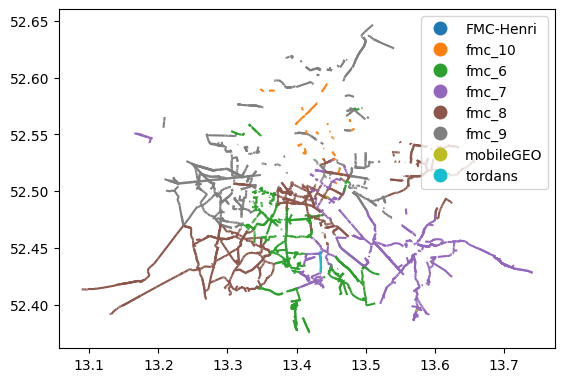

In [10]:
gdf.plot(column="user_name", legend=True)

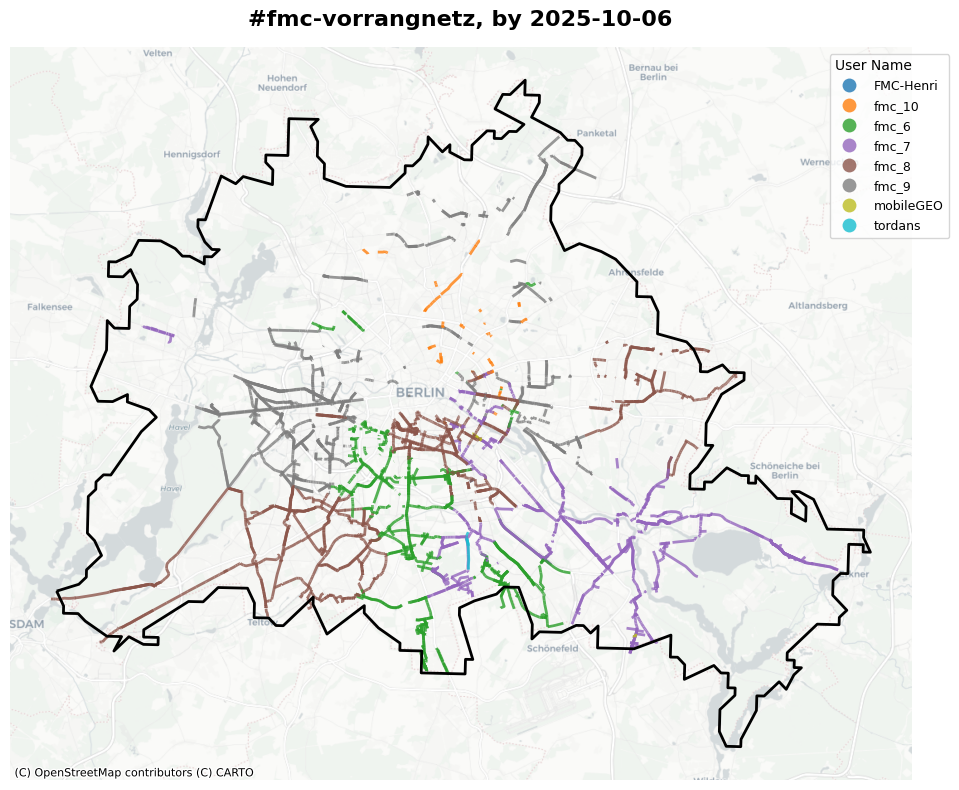

In [ ]:


# Daten laden
lk = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/refs/heads/main/4_kreise/1_sehr_hoch.geo.json")
shape = lk[lk.NAME_3 == "Berlin"]

# reprojizieren in Web Mercator
gdf_3857 = gdf.to_crs(epsg=3857)
shape_3857 = shape.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))


# Haupt-Layer (User)
gdf_3857.plot(
    ax=ax,
    column="user_name",
    legend=True,
    cmap="tab10",
    alpha=0.8,
    linewidth=2,
)

# 🔹 Berlin-Shape hinzufügen (kein Legendeneintrag)
shape_3857.boundary.plot(
    ax=ax,
    color="black",       # oder z. B. "black", "darkgrey"
    linewidth=2,
    label="_nolegend_" # verhindert Legendeneintrag
)


# Basemap mit höherer Auflösung (höherer Zoom = schärfer)
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    zoom=11,              # 🔹 probiere z.B. 12–16 für mehr Detail
    attribution_size=8,   # kleinere Attribution
)

# Achsen ausblenden
ax.set_axis_off()

# Legende schöner formatieren
leg = ax.get_legend()
leg.set_title("User Name")
leg.set_bbox_to_anchor((1.05, 1))
leg._legend_box.align = "left"
for text in leg.get_texts():
    text.set_fontsize(9)

# 🔹 Titel hinzufügen
ax.set_title(
    "#fmc-vorrangnetz, by 2025-10-06",
    fontsize=16,
    fontweight="bold",
    pad=15
)

plt.tight_layout()
plt.show()


In [12]:
duckdb.sql("""
SELECT MAX(valid_from) AS max_valid_from
FROM read_parquet(
  ['/home/simon/ohsome-planet/out-berlin_cs/contributions/history/*-*-history-contribs.parquet',
   '/home/simon/ohsome-planet/out-berlin_cs/contributions/latest/*-*-latest-contribs.parquet'],
  union_by_name = true
);
""").show()

┌──────────────────────────┐
│      max_valid_from      │
│ timestamp with time zone │
├──────────────────────────┤
│ 2025-10-06 01:57:52+02   │
└──────────────────────────┘



In [20]:
import duckdb
duckdb.sql("""
DESCRIBE SELECT * 
FROM read_parquet('/home/simon/ohsome-planet/out-berlin_cs/contributions/history/way-*-history-contribs.parquet')
""").df()


,column_name,column_type,null,key,default,extra
0,status,VARCHAR,YES,None,None,None
1,valid_from,TIMESTAMP WITH TIME ZONE,YES,None,None,None
2,valid_to,TIMESTAMP WITH TIME ZONE,YES,None,None,None
3,osm_type,VARCHAR,YES,None,None,None
4,osm_id,BIGINT,YES,None,None,None
5,osm_version,INTEGER,YES,None,None,None
6,osm_minor_version,INTEGER,YES,None,None,None
7,osm_edits,INTEGER,YES,None,None,None
8,osm_last_edit,TIMESTAMP WITH TIME ZONE,YES,None,None,None
9,user,"STRUCT(id INTEGER, ""name"" VARCHAR)",YES,None,None,None


In [ ]:
____

In [6]:
duckdb.sql("""INSTALL spatial; LOAD spatial;

CREATE OR REPLACE TABLE tmp2 AS
SELECT
  ST_GeomFromWKB(geometry)              AS geom,
  tags,
  "user"                                 AS usr,         -- 'user' quoten/aliasen
  changeset,
  osm_type,
  osm_id,
  osm_version,
  valid_from,
  contrib_type,
  length,                                -- m
  length_delta                           -- m (Netto je Version)
FROM read_parquet(
  ['~/ohsome-planet/out-berlin_cs/contributions/history/way*-*-history-contribs.parquet',
   '~/ohsome-planet/out-berlin_cs/contributions/latest/way*-*-latest-contribs.parquet'],
  union_by_name=true
)
WHERE COALESCE(changeset.tags.hashtags,'') ILIKE '%#fmc_vorrangnetz%';
""")




FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [7]:
duckdb.sql("""SELECT
  ROUND(SUM(CASE WHEN length_delta > 0 THEN  length_delta ELSE 0 END)/1000.0, 2) AS km_added,
  ROUND(SUM(CASE WHEN length_delta < 0 THEN -length_delta ELSE 0 END)/1000.0, 2) AS km_deleted
FROM tmp2
WHERE osm_type = 'way'
  AND tags['highway'] IS NOT NULL
  AND length_delta IS NOT NULL;
""")

┌──────────┬────────────┐
│ km_added │ km_deleted │
│  double  │   double   │
├──────────┼────────────┤
│     70.8 │      38.53 │
└──────────┴────────────┘

In [8]:
duckdb.sql("""SELECT
  usr.name AS mapper,
  ROUND(SUM(CASE WHEN length_delta > 0 THEN  length_delta ELSE 0 END)/1000.0, 2) AS km_added,
  ROUND(SUM(CASE WHEN length_delta < 0 THEN -length_delta ELSE 0 END)/1000.0, 2) AS km_deleted
FROM tmp2
WHERE osm_type='way' AND tags['highway'] IS NOT NULL AND length_delta IS NOT NULL
GROUP BY mapper
ORDER BY km_added DESC;
""")

┌───────────┬──────────┬────────────┐
│  mapper   │ km_added │ km_deleted │
│  varchar  │  double  │   double   │
├───────────┼──────────┼────────────┤
│ fmc_7     │    39.54 │      15.91 │
│ fmc_9     │    13.69 │       8.47 │
│ fmc_8     │     9.97 │       9.83 │
│ fmc_6     │     4.61 │       1.34 │
│ fmc_10    │     2.87 │       2.87 │
│ tordans   │     0.09 │       0.09 │
│ mobileGEO │     0.02 │       0.02 │
│ FMC-Henri │      0.0 │        0.0 │
└───────────┴──────────┴────────────┘